<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exercise 8: Point Pattern Analysis</h2>
<h3>IT University of Copenhagen, Spring 2024</h3>
<h3>Instructor: Ditte Stavski</h3>
</div>

This notebook was adapted from:
* A course on geographic data science: https://darribas.org/gds_course/content/bH/diy_H.html


In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from ipywidgets import interact, fixed

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [9]:
plt.style.use('ggplot')
plt.xkcd()

## Task I: AirBnb distribution in Copenhagen

In this task, you will explore patterns in the distribution of the location of AirBnb properties in Copenhagen from [Inside AirBnb](http://insideairbnb.com). We are going to read a file with the locations of the properties available as of December 2021:




**Make sure you are connected to the internet when you run this cell :)**


In [11]:
url_abb = 'http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2021-12-28/visualisations/listings.csv'

abb_df = pd.read_csv(url_abb)

abb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9726 entries, 0 to 9725
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              9726 non-null   int64  
 1   name                            9725 non-null   object 
 2   host_id                         9726 non-null   int64  
 3   host_name                       9722 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   9726 non-null   object 
 6   latitude                        9726 non-null   float64
 7   longitude                       9726 non-null   float64
 8   room_type                       9726 non-null   object 
 9   price                           9726 non-null   int64  
 10  minimum_nights                  9726 non-null   int64  
 11  number_of_reviews               9726 non-null   int64  
 12  last_review                     84

This gives us a table with the following information:

In [15]:
abb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,6983,Copenhagen 'N Livin',16774,Simon,NaN,Nrrebro,55.68641,12.54741,Private room,380,2,168,2019-07-19,1.12,1,0,0,NaN
1,26057,Lovely house - most attractive area,109777,Kari,NaN,Indre By,55.69196,12.57637,Entire home/apt,2400,4,55,2021-12-06,0.56,1,359,5,NaN
2,31094,"Very central and cozy, new kitchen",129976,Ebbe,NaN,Vesterbro-Kongens Enghave,55.66539,12.55639,Entire home/apt,750,2,17,2017-08-25,0.12,1,0,0,NaN
3,32379,120 m2 artist flat on Vesterbro,140105,Lise,NaN,Vesterbro-Kongens Enghave,55.67297,12.55327,Entire home/apt,1153,3,76,2021-10-18,0.55,2,92,3,NaN
4,32841,Cozy flat for Adults/Quiet for kids,142143,Anders & Maria,NaN,sterbro,55.71176,12.57091,Entire home/apt,617,100,7,2016-09-15,0.05,1,204,0,NaN


The dataset contains geometries in the form of long, lat coordinates - but you have to construct the geometry object before we continue working with them:

In [28]:
# ADD YOUR CODE HERE AND READ THE DATA INTO THE 'abb' GEODATAFRAME

abb = gpd.GeoDataFrame(abb_df, geometry=gpd.points_from_xy(abb_df.longitude, abb_df.latitude, crs='EPSG:4326'))

Also, for an ancillary geography, we will use the neighbourhoods provided by the same source. 
First we need to make sure that the CRS match and is suitable for analysis in DK (i.e. use **EPSG:25832**). 
Some of the data might not have a CRS defined, but based on the lat long coordinates, we can assume that it is in WGS84 / EPSG:4326.

**Make sure you are connected to the internet when you run this cell as well:**

In [31]:
# Filepath to neighbourhood geometries
url_neis = 'http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2021-12-28/visualisations/neighbourhoods.geojson'

neis = gpd.read_file(url_neis)

neis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        11 non-null     object  
 1   neighbourhood_group  0 non-null      object  
 2   geometry             11 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 392.0+ bytes


In [53]:
# ADD YOUR CODE HERE
abb = abb.to_crs('EPSG:25832')
neis = neis.to_crs('EPSG:25832')

**When reading files with 'æøå' we often end up with encoding errors (have a look at the neighbourhood names). To make sure that the names will work for a later join, run the cell below to rename the neighbourhoods.** 

Because of this it is always recommended to use a numerical ID rather than name if available.

In [54]:
# Fix neighbourhood names

rename_dict = {'Brnshj-Husum' : 'Broenshoej-Husum', 'sterbro' : 'Oesterbro', 'Nrrebro': 'Noerrebro', 'Amager st' : 'Amager Oest', 'Vanlse': 'Vanloese'}

abb.replace(rename_dict, inplace=True)
neis.replace(rename_dict, inplace=True)

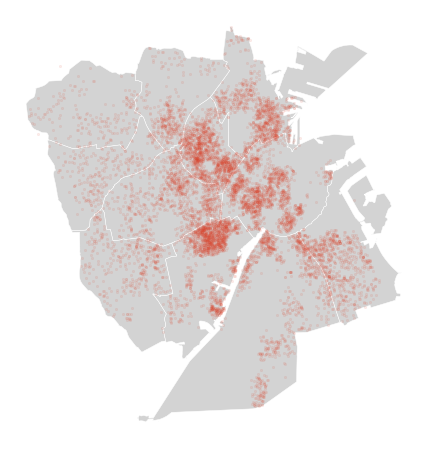

In [79]:
# Lets try to plot the two data sets together and see what it looks like

f, ax = plt.subplots(figsize=(8,8))
neis.plot(ax=ax, facecolor='lightgrey', edgecolor='white')
abb.plot(ax=ax, alpha=.1, markersize=6)
ax.set_axis_off()

# ADD YOUR CODE HERE
f.savefig('DANNEBROG.svg')

### With these at hand, get to work with the following challenges:

1. Create a Hex binning map of the property locations
2. Compute and display a kernel density estimate (KDE) of the distribution of the properties-
3. Using the neighbourhood layer:
    - Obtain a count of property by neighbourhood (nothe the neighbourhood name is present in the property table and you can connect the two tables through that).
    - Create a raw count choropleth.
    - Create a choropleth of the density of properties by polygon (for this step you thus need to find the number of airbnb-points per area for each polygon/neighbourhood.
    


**Think about the pros and cons of these different ways of visualising point density. Which one do you prefer? Why?**
    

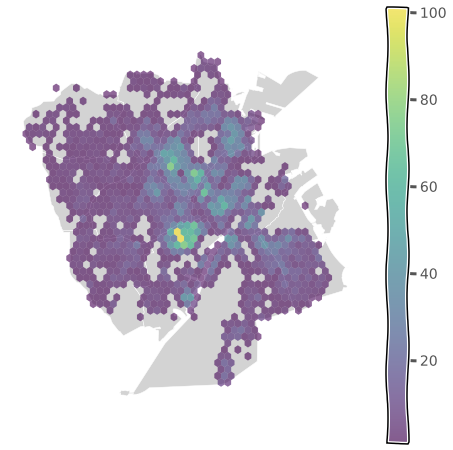

In [149]:
f, ax = plt.subplots(figsize=(8,8))

neis.plot(ax=ax, facecolor='lightgrey', edgecolor='white')
hb = ax.hexbin(abb.geometry.x, abb.geometry.y, gridsize=45, mincnt=1, alpha=.6, linewidths=0)
f.colorbar(hb)
ax.set_axis_off()

#basemap = cx.providers.CartoDB.DarkMatterNoLabels
#cx.add_basemap(ax=ax, crs=abb.crs, source=basemap)
#ax.set_xlim(abb.geometry.x.min(), abb.geometry.x.max())
#ax.set_ylim(abb.geometry.y.min(), abb.geometry.y.max())

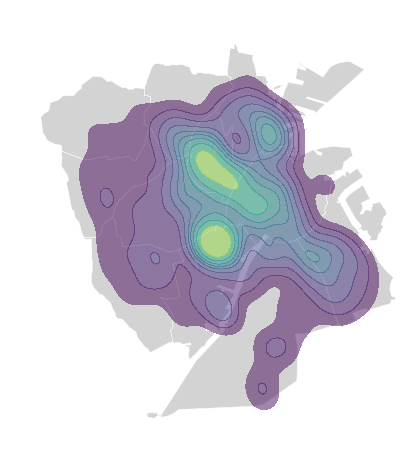

In [152]:
f, ax = plt.subplots(figsize=(8,8))

neis.plot(ax=ax, facecolor='lightgrey', edgecolor='white')
sns.kdeplot(x=abb.geometry.x, y=abb.geometry.y, shade=True, n_levels=10, cmap='viridis', alpha=.5)
ax.set_axis_off()

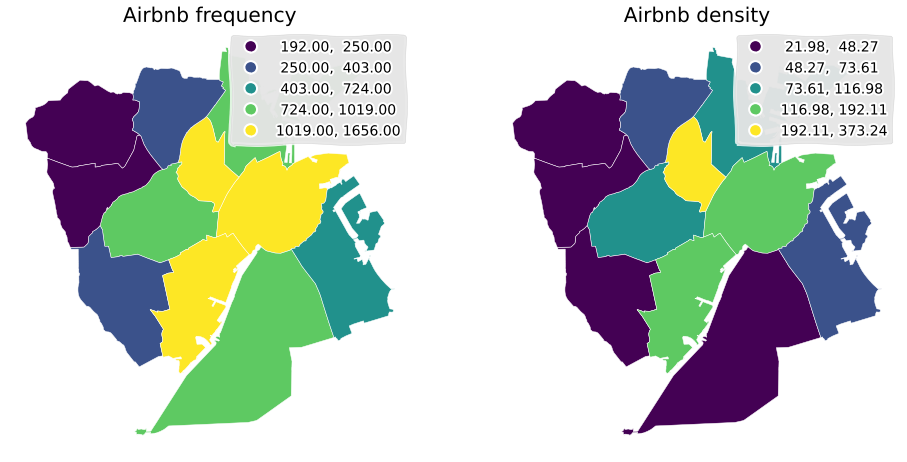

In [221]:
gdf = neis.merge(abb.groupby('neighbourhood').size().reset_index(), on='neighbourhood').rename(columns={0: 'sizequeen'})
gdf['density'] = gdf.sizequeen / (gdf.area * 1e-6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

gdf.plot(ax=ax1, facecolor='lightgrey', edgecolor='white', column='sizequeen', scheme='FisherJenks', legend=True)
gdf.plot(ax=ax2, facecolor='lightgrey', edgecolor='white', column='density', scheme='FisherJenks', legend=True)

ax1.set_title('Airbnb frequency')
ax2.set_title('Airbnb density')

for ax in f.axes:
    ax.set_axis_off()

## Task II: Clusters of Danish tourist attractions

For this part, we are going to use a dataset on attractions ('Seværdigheder') in Denmark.
The original data can be found here: https://dataforsyningen.dk/data/1038

The data set covers all of Denmark, but if you want to, you can select a specific region to analyse.

*Tip: The geometries in the data are polygons - but very small ones. It is a good idea to use their centroids instead of the original geometries.*


In [206]:
fp = 'data/pois.gpkg'

pois = gpd.read_file(fp)

In [212]:
# ADD YOUR CODE HERE
pois.geometry = pois.centroid

This is what we have to work with then:

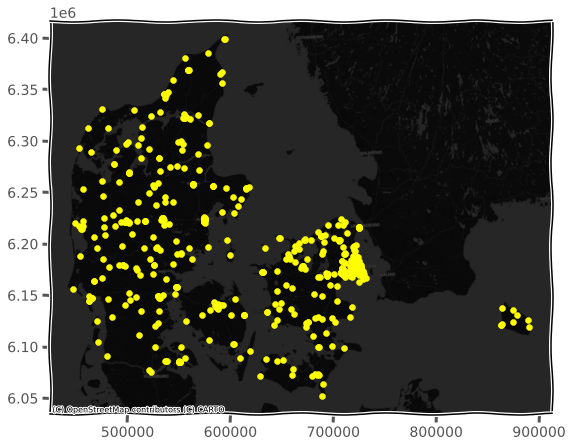

In [214]:
ax = pois.plot(
    color="xkcd:bright yellow", figsize=(9, 9)
)
cx.add_basemap(
    ax, 
    crs=pois.crs,
    source=cx.providers.CartoDB.DarkMatter
)

### With this at hand, get to work:

- Use the DBSCAN algorithm to identify clusters.
- Start with the following parameters: at least 3 sites for a cluster (`min_samples`) and a maximum of 1 Km (`eps`).
- Obtain the clusters and plot them on a map. *Does it pick up any interesting pattern?*.
- Based on the results above, tweak the values of both parameters to find the parameter values you think makes sense.
- What clusters can you identify?

#### Challenge 1
- Create a function that identifies clusters and plots then. Parameters should be the dataframe, min sample size and maximum distance.

#### Challenge 2
- Use [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) and your function from Challenge 1 to create an interactive plot that changes as you modify the cluster parameters (i.e. min sample size and max distance)

In [255]:
# ADD YOUR CODE HERE
def cluster(df, min_samples, max_dist):
    db = DBSCAN(eps=max_dist, min_samples=min_samples)
    df['x'] = df.geometry.x
    df['y'] = df.geometry.y
    clusters = db.fit_predict(df[['x', 'y']])
    return clusters

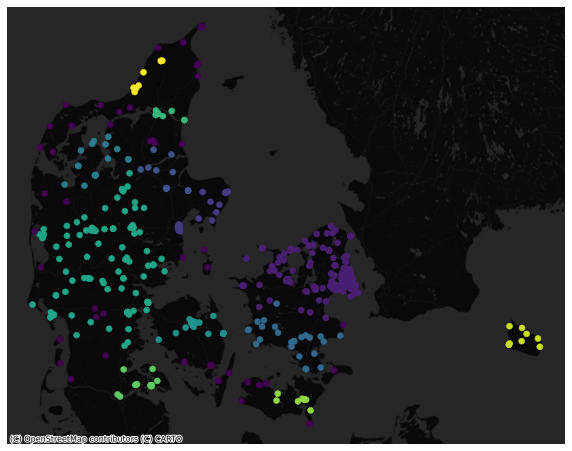

In [294]:
c = cluster(pois, 8, 20000)

f, ax = plt.subplots(figsize=(10,10))
pois.plot(ax=ax, c=c, legend=True)
ax.set_axis_off()
cx.add_basemap(ax=ax, crs=pois.crs, source=basemap)

In [316]:
def plot(df, max_dist, min_samples):
    c = cluster(df, max_dist, min_samples)

    f, ax = plt.subplots(figsize=(10,10))
    pois.plot(ax=ax, c=c, legend=True)
    ax.set_axis_off()
    cx.add_basemap(ax=ax, crs=pois.crs, source=basemap)
    plt.show()
    
    return f, ax

interact(
    plot,
    df=fixed(pois),
    max_dist=np.exp(np.linspace(1, 10, 10)).astype(int),
    min_samples=range(1, 100)
);

interactive(children=(Dropdown(description='max_dist', options=(2, 7, 20, 54, 148, 403, 1096, 2980, 8103, 2202…

array([2.71828183e+00, 1.62754791e+05, 9.74480345e+09, 5.83461743e+14,
       3.49342711e+19, 2.09165950e+24, 1.25236317e+29, 7.49841700e+33,
       4.48961282e+38, 2.68811714e+43])

In [296]:
import numpy as np